# []

In [3]:
# inbuilt 
import os
import sys
import math

# most common
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch as tt
import torch.nn as nn
import torch.optim as oo
import torch.functional as ff
import torch.distributions as dd
import torch.utils.data as ud

# custom
import known
from known.basic import pj
from known.basic.common import Verbose as verb
import known.ktorch as kt

print(f'{sys.version=}\n{np.__version__=}\n{tt.__version__=}\n{known.__version__=}')

sys.version='3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]'
np.__version__='1.22.2'
tt.__version__='1.10.1+cu102'
known.__version__='0.0.1'


# Select DataSet

## (1) Sinus

In [4]:
seqlen = 10
cols = ('1','2', '3')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/sinu.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/sinu_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/sinu_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=False, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x144060ac6a0>,
 <known.ktorch.data.SeqDataset at 0x14465284400>)

# (2) custom - g

In [5]:
seqlen = 25
cols = ('1','2')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/g.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/g_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/g_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x1440beddc10>,
 <known.ktorch.data.SeqDataset at 0x1440beafd90>)

# (3) custom - h

In [6]:
seqlen = 40
cols = ('1','2')
input_size = len(cols)

ds_test  = kt.SeqDataset.from_csv(pj('data_rnn/h.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_train = kt.SeqDataset.from_csv(pj('data_rnn/h_train.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)
ds_val = kt.SeqDataset.from_csv(pj('data_rnn/h_test.csv'), cols=cols, 
                seqlen=seqlen, reverse=True, normalize=True, squeeze_label=True, dtype=tt.float32)

ds_train, ds_val, ds_test

(<known.ktorch.data.SeqDataset at 0x1440bee9820>,
 <known.ktorch.data.SeqDataset at 0x144652767f0>)

# Define Regression Network

In [7]:
dt = tt.float32
dropout=0.0
batch_first = True
num_layers = 2
hidden_size = 32
bidirectional = False
bias = True
nonlinearity='tanh'

hidden_sizes = [hidden_size for _ in range(num_layers)]
stack_output=True
use_rnn=False

class RNNRegression(nn.Module):
    def __init__(self, rnn, output_size) -> None:
        super().__init__()
        self.rnn = rnn
        self.fc = nn.Linear(output_size, rnn.input_size)

    def forward(self, X):
        x, *_ = self.rnn(X)
        return self.fc(x)

## encapsulate rnns

In [8]:
networks = dict(

elman_kt = RNNRegression(kt.ELMAN(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=None,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=None,
        hypers=None,
        return_last=True,
        dtype=dt,
        device=None),
    output_size = hidden_size),

gru_kt = RNNRegression(kt.GRU(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=None,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=None,
        hypers=None,
        return_last=True,
        dtype=dt,
        device=None),
    output_size = hidden_size),

lstm_kt = RNNRegression(kt.LSTM(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=None,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=None,
        hypers=None,
        return_last=True,
        dtype=dt,
        device=None),
    output_size = hidden_size),

mgu_kt = RNNRegression(kt.MGU(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=None,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=None,
        hypers=None,
        return_last=True,
        dtype=dt,
        device=None),
    output_size = hidden_size),

janet_kt = RNNRegression(kt.JANET(
        input_size=input_size,      
        i2h_sizes=hidden_sizes,      
        i2o_sizes=None,  
        o2o_sizes=None,  
        dropout=0.0,        
        batch_first=batch_first,  
        stack_output=stack_output, 
        i2h_bias = bias, 
        i2o_bias = True,
        o2o_bias = True,
        i2h_activations=(),
        i2o_activation=None,
        o2o_activation=None,
        last_activation=None,
        hypers=None,
        return_last=True,
        dtype=dt,
        device=None),
    output_size = hidden_size),

)

colors = {k:v for k,v in zip(networks.keys(), \
            [ 'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown' ])}

# (A) Train and Evaluate

elman_kt <class '__main__.RNNRegression'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 02:27:13.681452
-------------------------------------------
[*] Saved@ elman_kt.reg
-------------------------------------------
Final Training Loss: [3.484107983240392e-05]
Final Validation Loss: [6.221743387868628e-05]
End Training @ 2023-01-24 02:28:02.456472, Elapsed Time: [0:00:48.775020]


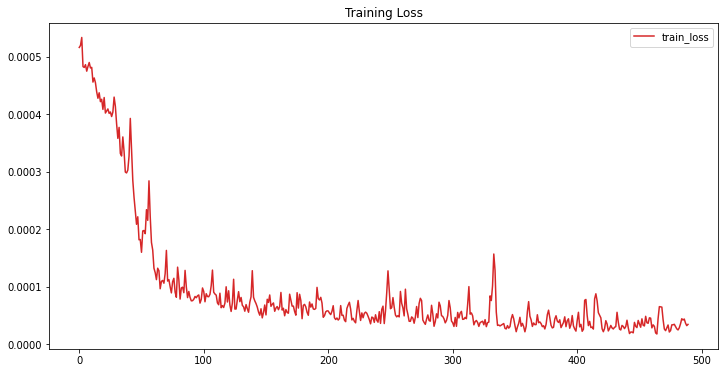

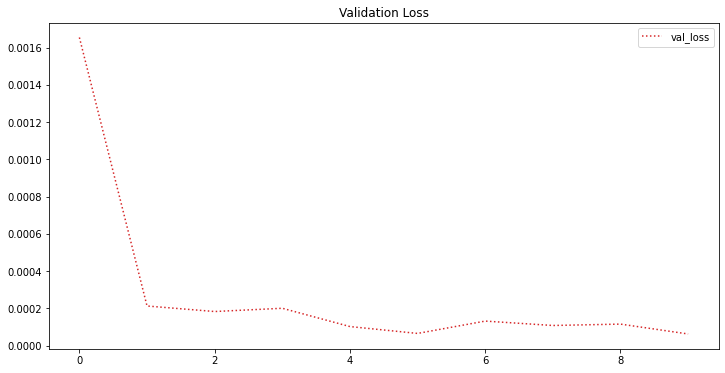

Testing samples: [460]
Testing batches: [1]
Testing Loss: 3.128072785330005e-05
gru_kt <class '__main__.RNNRegression'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 02:28:02.738471
-------------------------------------------
[*] Saved@ gru_kt.reg
-------------------------------------------
Final Training Loss: [2.98171624308452e-05]
Final Validation Loss: [0.00022552897280547768]
End Training @ 2023-01-24 02:30:40.396507, Elapsed Time: [0:02:37.658036]


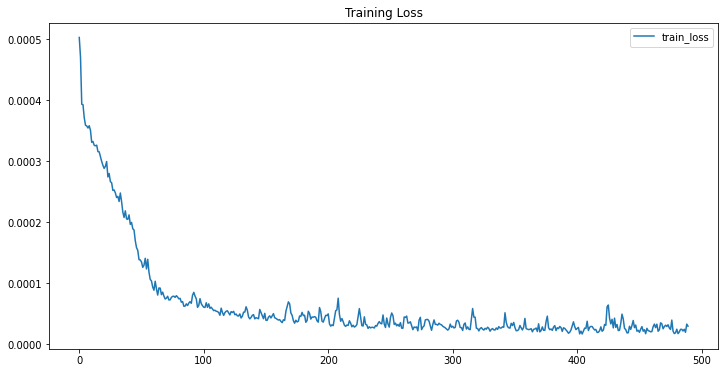

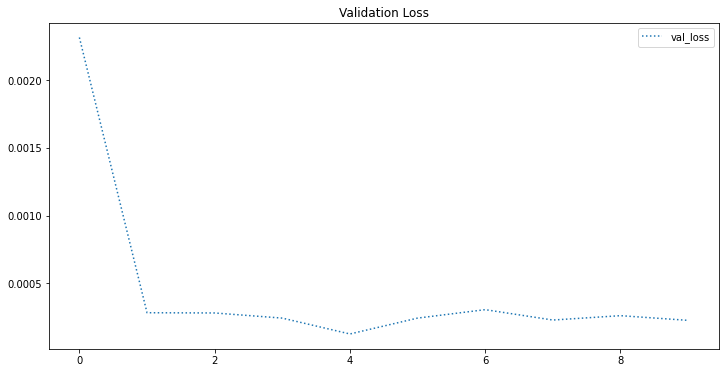

Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.00011242646723985672
lstm_kt <class '__main__.RNNRegression'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 02:30:40.613756
-------------------------------------------
[*] Saved@ lstm_kt.reg
-------------------------------------------
Final Training Loss: [4.330160900281044e-05]
Final Validation Loss: [0.0008936712401919067]
End Training @ 2023-01-24 02:33:34.021216, Elapsed Time: [0:02:53.407460]


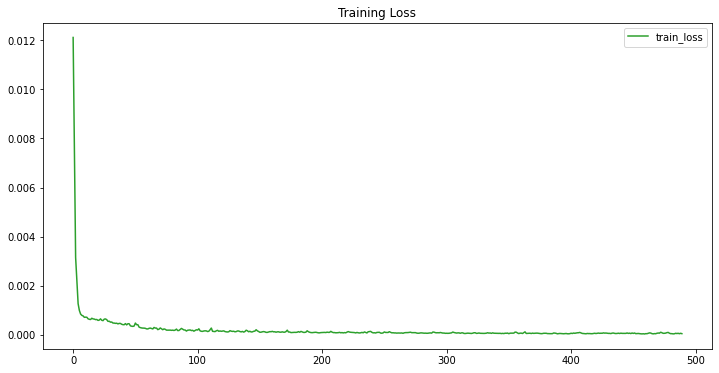

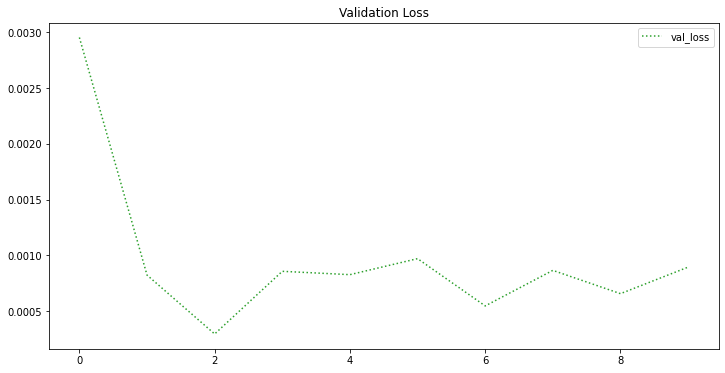

Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.0006612700526602566
mgu_kt <class '__main__.RNNRegression'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 02:33:34.253602
-------------------------------------------
[*] Saved@ mgu_kt.reg
-------------------------------------------
Final Training Loss: [2.0929228458044236e-05]
Final Validation Loss: [0.00010567095159785822]
End Training @ 2023-01-24 02:35:35.384134, Elapsed Time: [0:02:01.130532]


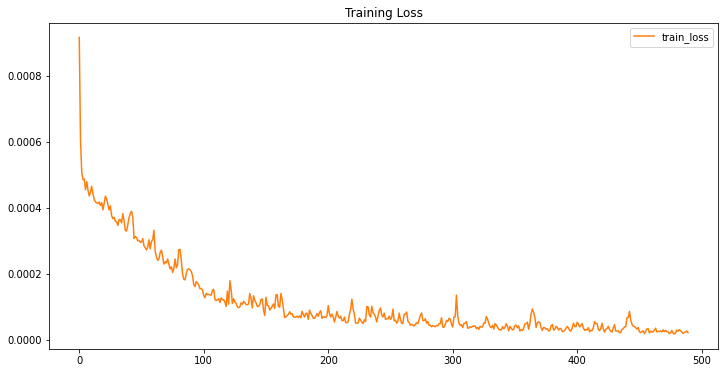

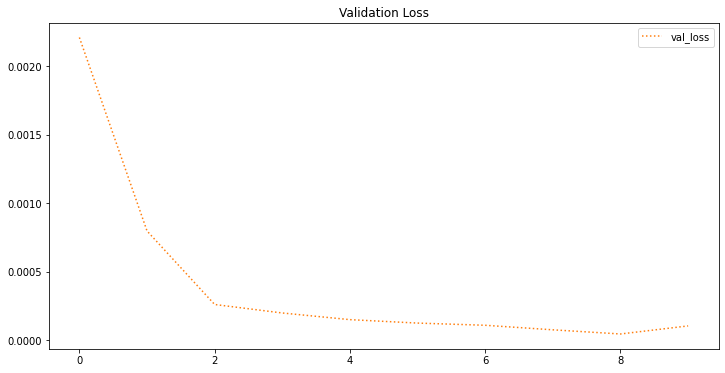

Testing samples: [460]
Testing batches: [1]
Testing Loss: 2.847152245522011e-05
janet_kt <class '__main__.RNNRegression'>
Training samples: [310]
Training batches: [10]
Validation samples: [110]
Validation batches: [1]
Start Training @ 2023-01-24 02:35:35.598134
-------------------------------------------
[*] Saved@ janet_kt.reg
-------------------------------------------
Final Training Loss: [7.404739353660262e-05]
Final Validation Loss: [0.00019460279145278037]
End Training @ 2023-01-24 02:37:36.363465, Elapsed Time: [0:02:00.765331]


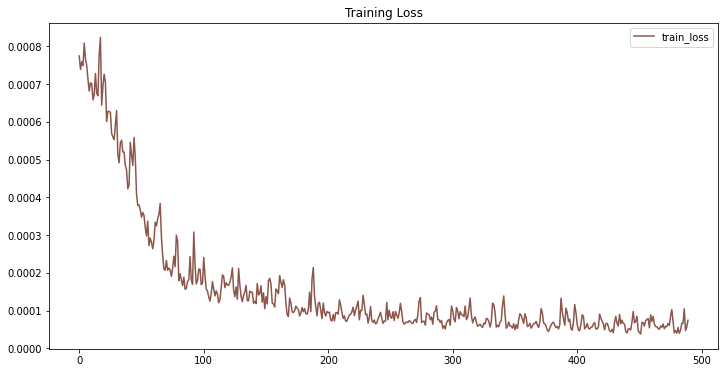

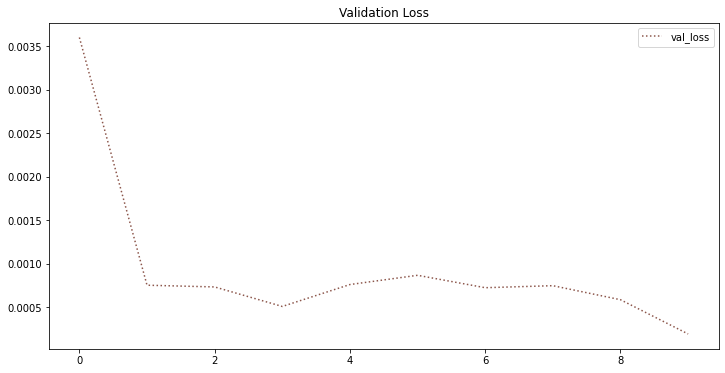

Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.0009263744577765465


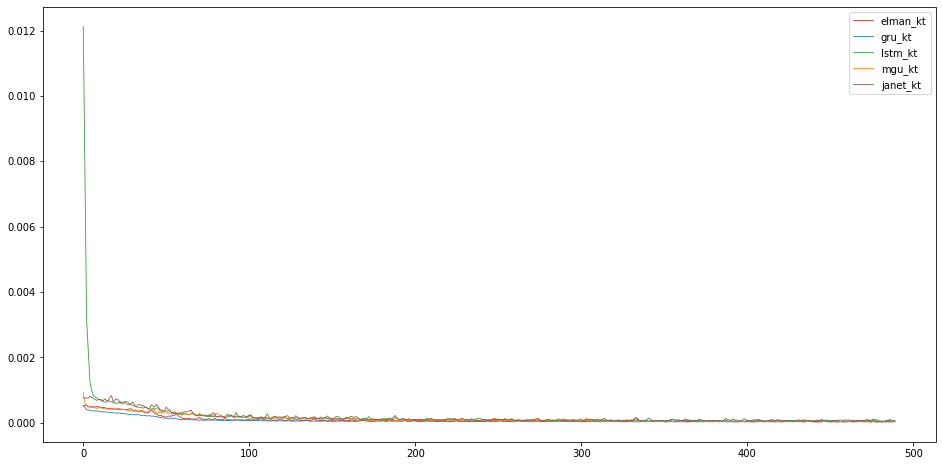

In [9]:
test_loss, train_loss = {}, {}
for key,model in networks.items():
    print(key, model.__class__)
    epochs = 500
    batch_size=32
    shuffle=True
    validation_freq = int(epochs/10)
    criterion=nn.MSELoss()
    lr = 0.0025
    weight_decay = 0.0
    optimizer=oo.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lrs=oo.lr_scheduler.LinearLR(optimizer, start_factor= 1.0, end_factor=0.7, total_iters=epochs)

    early_stop_train=kt.QuantiyMonitor('TrainLoss', patience=50, delta=0.00001)
    early_stop_val=kt.QuantiyMonitor('ValLoss', patience=50, delta=0.00001)
    #checkpoint_freq=int(epochs/4)
    save_path=f'{key}.reg'
    loss_plot_start = int(epochs/50)

    trainer = kt.Trainer(model)
    trainer.optimizer=optimizer
    trainer.criterion=criterion

    trainer.fit(training_data=ds_train, validation_data=ds_val, 
                epochs=epochs, batch_size=batch_size,shuffle=shuffle,validation_freq=validation_freq,
                save_path=save_path, use_rnn=use_rnn, verbose=1)

    trainer.plot_results(color=colors[key],loss_plot_start=loss_plot_start)

    mtl, _ = trainer.evaluate(ds_test, batch_size=None, use_rnn=use_rnn)
    train_loss[key] = np.array(trainer.train_loss_history)
    test_loss[key] = mtl
    print('=================================================')
    
plt.figure(figsize=(16,8))
for k,v in train_loss.items():
    plt.plot(np.mean(v, axis=1)[loss_plot_start:], label=k, color=colors[k], linewidth=0.8)
plt.legend()
plt.show()

# (B) Load and Evaluate

In [10]:
for key,model in networks.items():
    kt.load_state(model, f'{key}.reg')
test_loss={}

for key,model in networks.items():
    trainer = kt.Trainer(model)
    trainer.criterion=nn.MSELoss() 
    mtl, tl = trainer.evaluate(ds_test, use_rnn=use_rnn)

    test_loss[key] = mtl

Testing samples: [460]
Testing batches: [1]
Testing Loss: 3.128072785330005e-05
Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.00011242646723985672
Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.0006612700526602566
Testing samples: [460]
Testing batches: [1]
Testing Loss: 2.847152245522011e-05
Testing samples: [460]
Testing batches: [1]
Testing Loss: 0.0009263744577765465


# Plot Evaluation Results

elman_kt:	3.128072785330005e-05
gru_kt:	0.00011242646723985672
lstm_kt:	0.0006612700526602566
mgu_kt:	2.847152245522011e-05
janet_kt:	0.0009263744577765465


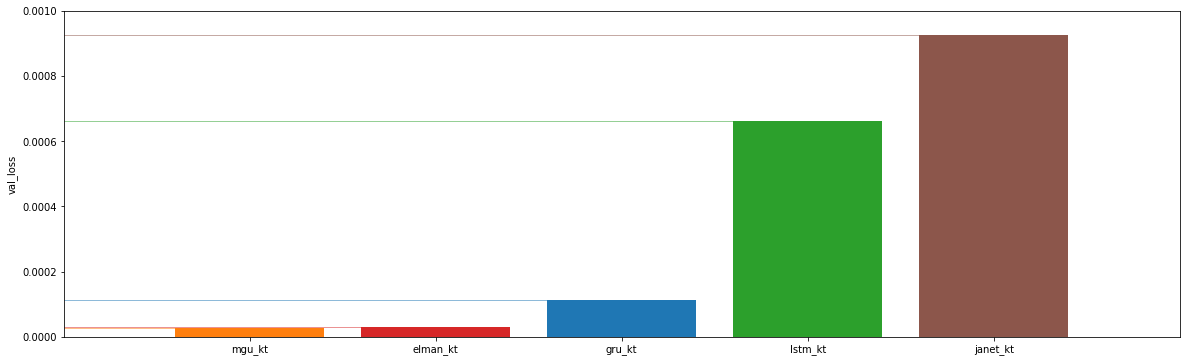

In [11]:
y = []
l = []
c = []
for k,v in test_loss.items():
    print(f'{k}:\t{v}')
    y.append(v)
    l.append(k)
    c.append(colors[k])

x= range(len(test_loss))

y = np.array(y)
l = np.array(l)
t = np.argsort(y)

plt.figure(figsize=(20,6))
plt.xlim(-1,len(x))
plt.ylim(0,0.001)
for i in t:
    plt.bar([i] , y[t[i]], color=c[t[i]] )
    plt.hlines(y[t[i]], -1, i, linestyles='solid', linewidth=0.5, color=c[t[i]])
plt.xticks(x, l[t])
plt.ylabel('val_loss')
plt.show()

# Manual Testing

## test dataset

In [12]:
res = {}
for key,model in networks.items():
    print(key, model.__class__)
    model.eval()
    with tt.no_grad():
        dl = iter(ds_test.dataloader(batch_size=int(len(ds_test)*1.0)))
        Xv, Yv = next(dl)
        Pv = model(Xv)
        res[key]=Pv #print(Xv.shape, Yv.shape, Pv.shape)



elman_kt <class '__main__.RNNRegression'>
gru_kt <class '__main__.RNNRegression'>
lstm_kt <class '__main__.RNNRegression'>
mgu_kt <class '__main__.RNNRegression'>
janet_kt <class '__main__.RNNRegression'>


## visualize

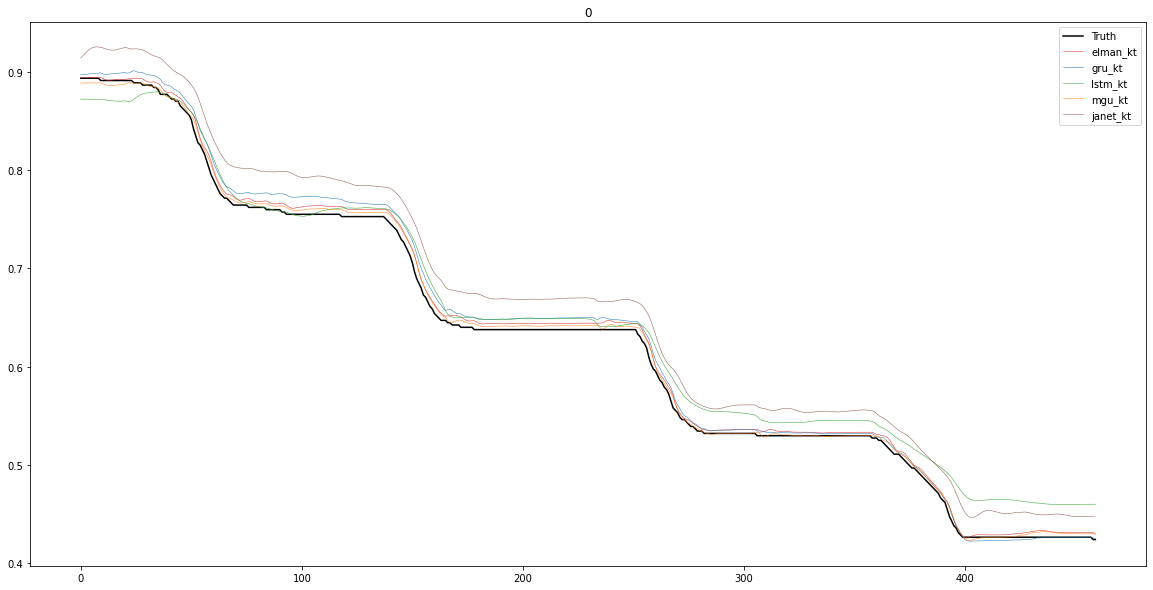

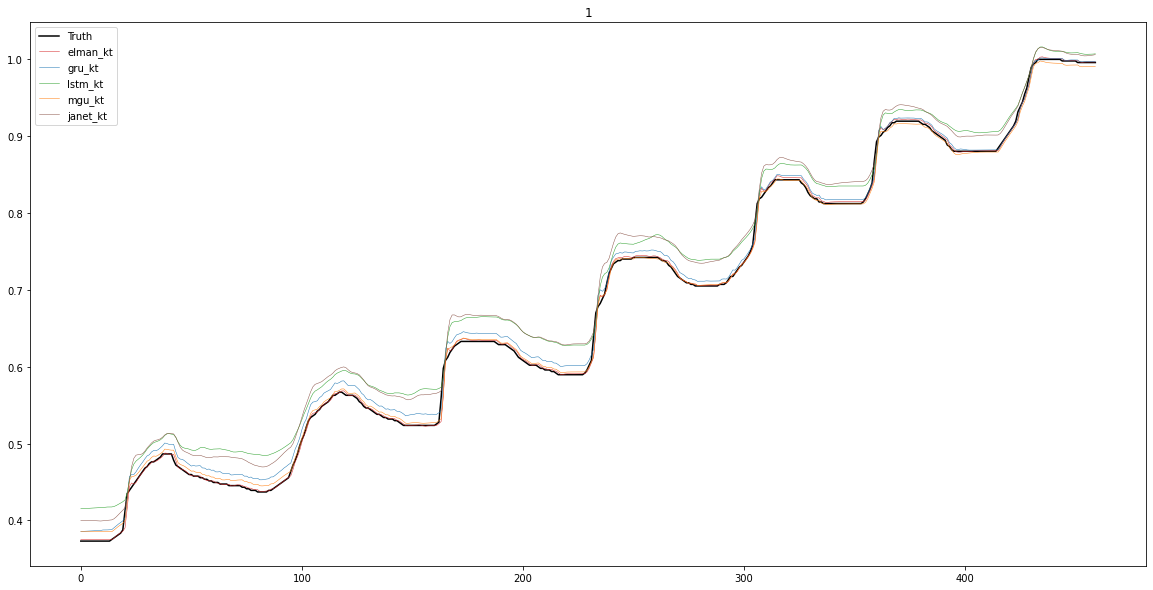

In [13]:
for i in range(input_size):
    plt.figure(figsize=(20,10))
    plt.title(f'{i}')
    
    plt.plot(Yv[:,i], color='black', label='Truth')
    for key,r in res.items():
        plt.plot(r[:,i], color=colors[key], label=f'{key}', linewidth=0.5)
    plt.legend()
    plt.show()
    plt.close()
    print('=================================================')